# X-Inactivation Cell Type Differences DV Analysis

Detection of X-inactivation via differential variance

No detectable differences.

In [1]:
%env PYTHONPATH='/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc'

env: PYTHONPATH='/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc'


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import scipy.sparse as sparse
import seaborn as sns
import imp
import time
from statsmodels.stats.multitest import fdrcorrection

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/x_inactivation_data/'

### Read the the Lupus AnnData object

In [7]:
adata = sc.read(data_path + 'lupus_annotated_nonorm_V6_x_genes.h5ad')

### Read cell type and individual information

In [8]:
#ct_list = pd.read_csv(data_path + 'lupus_ct_list.csv')['ct_cov'].tolist()
ct_list = ['Tc', 'Th', 'cM', 'B', 'NK']

In [9]:
ind_list = pd.read_csv(data_path + 'lupus_ind_list.csv')
males = set(ind_list.query('Female == 0.0').ind_cov)
females = set(ind_list.query('Female == 1.0').ind_cov)

### Read DE and DV results

The results are computed in the `compute_x_inactivation_statistics.py` script in the Wynton cluster.

In [10]:
de_t_stats = {ct:pd.read_csv(data_path + 'ind_ct_combined_statistics/{}_de_t_stats.csv'.format(ct), index_col=0).T.dropna(how='all') for ct in ct_list}
dv_t_stats = {ct:pd.read_csv(data_path + 'ind_ct_combined_statistics/{}_dv_t_stats.csv'.format(ct), index_col=0).T.dropna(how='all') for ct in ct_list}

de_pval = {ct:pd.read_csv(data_path + 'ind_ct_combined_statistics/{}_de_pvals.csv'.format(ct), index_col=0).T.dropna(how='all') for ct in ct_list}
dv_pval = {ct:pd.read_csv(data_path + 'ind_ct_combined_statistics/{}_dv_pvals.csv'.format(ct), index_col=0).T.dropna(how='all') for ct in ct_list}

mean = {ct:pd.read_csv(data_path + 'ind_ct_combined_statistics/{}_ct_mean.csv'.format(ct), index_col=0).T.dropna(how='all') for ct in ct_list}
var = {ct:pd.read_csv(data_path + 'ind_ct_combined_statistics/{}_ct_var.csv'.format(ct), index_col=0).T.dropna(how='all') for ct in ct_list}


### Male vs female analysis

In [11]:
for ct in ct_list:

    mean_pvals = np.zeros(mean[ct].shape[0])
    var_pvals = np.zeros(var[ct].shape[0])
    
    var_diff = np.zeros(var[ct].shape[0])
    
    # Compute difference in means
    idx = 0
    for gene, row in mean[ct].iterrows():
        _, mean_pvals[idx] = stats.mannwhitneyu(row[males], row[females])
        idx += 1
        
    # Compute difference in vars
    idx = 0
    for gene, row in var[ct].iterrows():
        var_diff[idx] = row[females].mean() - row[males].mean()
        _, var_pvals[idx] = stats.mannwhitneyu(row[males], row[females])
        idx += 1
        
        
    mean[ct]['sex_diff_pval'] = mean_pvals
    var[ct]['sex_diff_pval'] = var_pvals
    var[ct]['var_diff'] = var_diff
    
    _, mean[ct]['sex_diff_fdr'] = fdrcorrection(mean_pvals)
    _, var[ct]['sex_diff_fdr'] = fdrcorrection(var_pvals)
    
    print(ct)
    print('mean', mean[ct].query('sex_diff_fdr < 0.1').index.tolist())
    print('var', var[ct].query('sex_diff_fdr < 0.1 & var_diff > 0').index.tolist())
    print()

Tc
mean ['TRAPPC2', 'SCML1', 'SEPT6', 'KDM5C', 'ARMCX5', 'MAP7D2', 'RRAGB', 'LAS1L', 'RBM10', 'PPP2R3B', 'CHM', 'HTATSF1', 'FAM156B', 'CXorf38', 'TCEANC', 'KRBOX4', 'MST4', 'MAP7D3', 'SLITRK4', 'CTAG2', 'USP9X', 'MBTPS2', 'STAG2', 'RAB40A', 'BEX5', 'ERAS', 'DLG3', 'SYAP1', 'L1CAM', 'MED14', 'EIF1AX', 'AP1S2', 'RBMX', 'DDX3X', 'XIST', 'PHF6', 'KCND1', 'ACSL4', 'MOSPD1', 'GPC4', 'ALG13', 'FUNDC1', 'RBM41', 'SMC1A', 'MECP2', 'CA5B', 'RHOXF2B', 'ATP1B4', 'HDHD1', 'PRKX', 'MBNL3', 'ARHGEF9', 'AKAP17A', 'ZRSR2', 'KDM6A', 'ATP11C', 'WDR44', 'MORF4L2', 'VSIG1', 'LINC00894', 'POLA1', 'MSL3', 'ZFX', 'ABCD1', 'PRICKLE3', 'OGT', 'TSIX', 'SASH3', 'FAM156A', 'GPR82', 'ASB11', 'HCFC1', 'UTP14A', 'EIF2S3', 'TRMT2B', 'GPRASP1', 'TXLNG', 'MAP3K15', 'XAGE3', 'PNPLA4', 'MAOA', 'HUWE1', 'JPX', 'MAOB', 'THOC2', 'SMARCA1', 'GNL3L', 'ZNF157', 'TLR7', 'RPS4X', 'GPR173', 'ARHGEF6', 'DDX26B']
var ['MAP7D2']

Th
mean ['SEPT6', 'TIMP1', 'SYAP1', 'EIF1AX', 'DDX3X', 'XIST', 'CD40LG', 'SMC1A', 'CA5B', 'PRKX', 'ZRSR2'

In [12]:
mean_T = {ct:mean[ct].T for ct in ct_list}
var_T = {ct:var[ct].T for ct in ct_list}

for ct in ct_list:
    mean_T[ct]['sex'] = mean_T[ct].index.map(lambda x: 'male' if x in males else 'female')
    var_T[ct]['sex'] = var_T[ct].index.map(lambda x: 'male' if x in males else 'female')

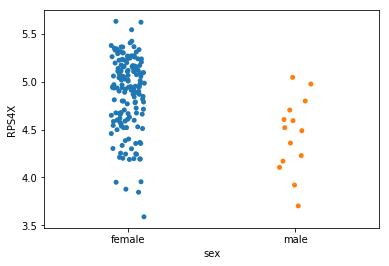

In [15]:
sns.stripplot(x='sex', y='RPS4X', data=mean_T['Tc'], jitter=True)
#sns.boxplot(x='sex', y='RPL36A', data=mean_T['Tc'])

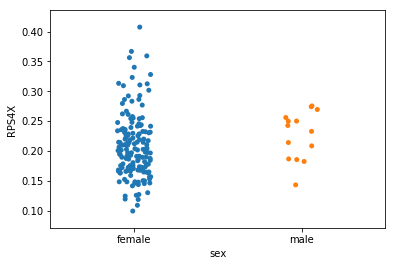

In [16]:
sns.stripplot(x='sex', y='RPS4X', data=var_T['Tc'], jitter=True)
#sns.boxplot(x='sex', y='XIST', data=var_T['Tc'])

In [23]:
sns.stripplot([0, 1], [
            var[ct].loc[gene][males].dropna(),
            var[ct].loc[gene][females].dropna()])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

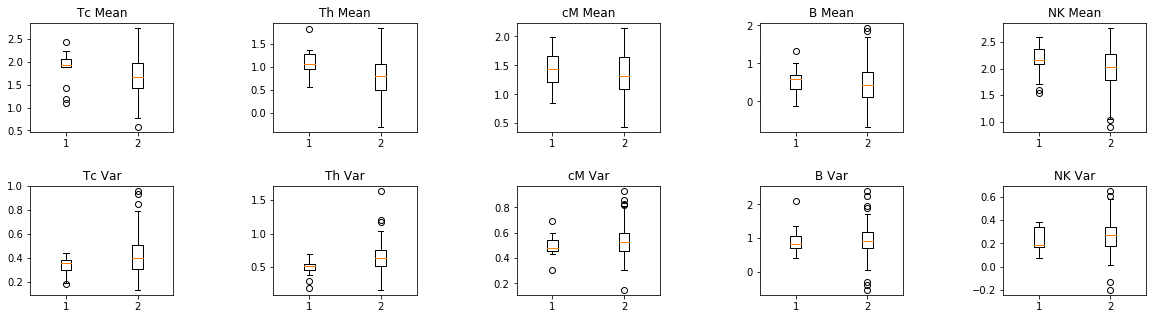

In [21]:
gene = 'CD99'
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace=0.7, hspace=0.5)

for idx, ct in enumerate(ct_list):
    try:
        plt.subplot(2, len(ct_list), idx+1);
        plt.title(ct + ' Mean')
        plt.boxplot([
            mean[ct].loc[gene][males].dropna(),
            mean[ct].loc[gene][females].dropna()])
    except: 
        continue

for idx, ct in enumerate(ct_list):
    try:
        plt.subplot(2, len(ct_list), len(ct_list) + idx+1);
        plt.title(ct + ' Var')
        plt.boxplot()
    except: 
        continue

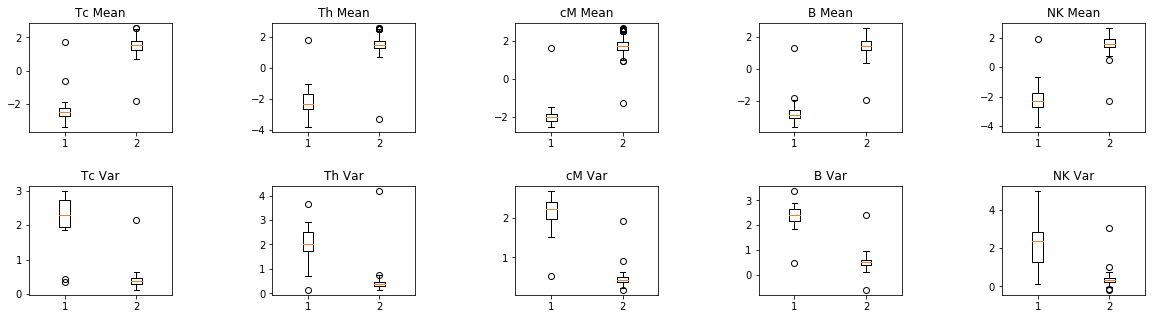

In [19]:
gene = 'XIST'
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace=0.7, hspace=0.5)

for idx, ct in enumerate(ct_list):
    try:
        plt.subplot(2, len(ct_list), idx+1);
        plt.title(ct + ' Mean')
        plt.boxplot([
            mean[ct].loc[gene][males].dropna(),
            mean[ct].loc[gene][females].dropna()])
    except: 
        continue

for idx, ct in enumerate(ct_list):
    try:
        plt.subplot(2, len(ct_list), len(ct_list) + idx+1);
        plt.title(ct + ' Var')
        plt.boxplot([
            var[ct].loc[gene][males].dropna(),
            var[ct].loc[gene][females].dropna()])
    except: 
        continue

### CT differences

In [61]:
female_dv = pd.read_csv(data_path + 'female_specific_ct_dv.csv', index_col=0)

In [117]:
def plot_ct_diff(gene):
    
    plt.figure(figsize=(20, 5));
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    
    plt.subplot(2, 2, 1);
    plt.boxplot([mean[ct].loc[gene][females].dropna().values for ct in ct_list]);
    plt.xticks(np.arange(len(ct_list))+1, ct_list)
    plt.title('Mean - female');

    plt.subplot(2, 2, 2);
    plt.boxplot([mean[ct].loc[gene][males].dropna().values for ct in ct_list]);
    plt.xticks(np.arange(len(ct_list))+1, ct_list)
    plt.title('Mean - male');
    
    plt.subplot(2, 2, 3);
    plt.boxplot([var[ct].loc[gene][females].dropna().values for ct in ct_list]);
    plt.xticks(np.arange(len(ct_list))+1, ct_list)
    plt.title('Var - female');

    plt.subplot(2, 2, 4);
    plt.boxplot([var[ct].loc[gene][males].dropna().values for ct in ct_list]);
    plt.xticks(np.arange(len(ct_list))+1, ct_list)
    plt.title('Var - male');

In [27]:
mean['cM'].shape

(257, 171)

In [30]:
temp = np.diag(np.load(data_path + 'IGTB986_B_ct_cov.npy'))

In [43]:
temp = pd.read_csv(data_path + 'ind_ct_combined_statistics/B_ct_mean.csv', index_col=0).T

In [44]:
temp

,1760_1760,901560200_901560200,1584_1584,1597_1597,1775_1775,900759200_900759200,1731_1731,IGTB645,IGTB1575,1623_1623,...,IGTB1840,IGTB1793,IGTB1819,IGTB1762,IGTB1901,IGTB1982,IGTB1952,IGTB1996,IGTB2065,IGTB1906
GRPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.250659,NaN
RGAG4,-3.073876,-2.990372,-5.191265,NaN,-5.677335,NaN,NaN,NaN,-5.079910,-4.394882,...,NaN,-5.171636,NaN,NaN,-4.893782,NaN,-5.877936,NaN,NaN,-5.817111
BRS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRAPPC2,-2.481478,-1.388578,-1.631331,-1.867188,-1.244461,NaN,-1.619080,-0.908188,-1.541891,-1.519334,...,-0.709449,-1.201845,-0.947873,-0.772171,-0.976719,-0.805441,-0.767261,-0.812616,-1.186287,-0.708871
ASB9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPR143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Metazoa_SRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STARD8,-4.113801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.809061,...,NaN,NaN,NaN,-5.397213,NaN,NaN,NaN,NaN,NaN,NaN
GJB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IGBP1,0.822486,0.209248,0.137271,1.197242,-0.146596,NaN,0.278639,-0.194043,0.509855,0.031170,...,0.605199,0.662921,0.527318,0.415110,0.283746,0.539426,0.428915,0.295850,0.526150,0.081700


In [38]:
mean['B'].shape

(45, 170)

In [36]:
temp.shape

(168, 814)

In [31]:
temp.shape

(813,)